In [2]:
import pandas as pd

import numpy as np

import scipy.optimize as opt

import matplotlib.pyplot as plt

import tkinter as tk
from tkinter import filedialog

In [13]:
window = tk.Tk()
window.title('File explorer')
window.geometry('300x150')

def browseFiles():
    filename = filedialog.askopenfilename(initialdir = '/',
                                         title = 'Select a .txt file',
                                         filetypes = (('text files','*.txt'),('','')))
    label_file_explorer.configure(text = 'File opened: '+filename)
    
label_file_explorer = tk.Label(window,
                              text='File explorer with Tkinter',
                               width=45, height=3,
                              fg = 'black')
button_explore = tk.Button(window,
                          text='Browse files',
                          command=browseFiles)

label_file_explorer.grid(column=1, row=1)
button_explore.grid(column=1, row=2)

window.mainloop()

In [ ]:
path = %pwd
corrected_path = path.replace('\\', '/')

data = pd.read_table(corrected_path+'/data/example.txt', delimiter='\t', lineterminator='\n')
data.head(15)

In [3]:
header = ['Pixel','1','2','3','Pixel.1','1.1','2.1','3.1']
data.columns = header
data.head()

,Pixel,1,2,3,Pixel.1,1.1,2.1,3.1
0,Area (cm2),0.064600,0.064600,0.064600,Area (cm2),0.064600,0.064600,0.064600
1,Efficiency (%),9.151790,9.355109,8.871294,Efficiency (%),9.151790,9.355109,8.871294
2,JSC (mA/cm2),18.686320,17.791890,16.817960,ISC (A),0.001207,0.001149,0.001086
3,VOC (V),0.940674,0.974644,0.961021,VOC (V),0.940674,0.974644,0.961021
4,FF,52.064650,53.948680,54.888460,FF,52.064650,53.948680,54.888460


In [4]:
JV = data[['Pixel','1','2','3']][10:]
JV.index = np.around(np.arange(float(JV.Pixel[10]),
                     float(JV.Pixel[len(JV)+9]),
                     float(JV.Pixel[11])-float(JV.Pixel[10])), decimals=2)
JV = JV.drop('Pixel', axis=1)
JV.head()

,1,2,3
-0.50,-19.78285,-18.60034,-17.54935
-0.45,-19.42376,-18.33774,-17.32498
-0.40,-19.29082,-18.22576,-17.22680
-0.35,-19.18125,-18.17005,-17.16703
-0.30,-19.10375,-18.10113,-17.10601


In [5]:
JV['1'][0]

-18.68632

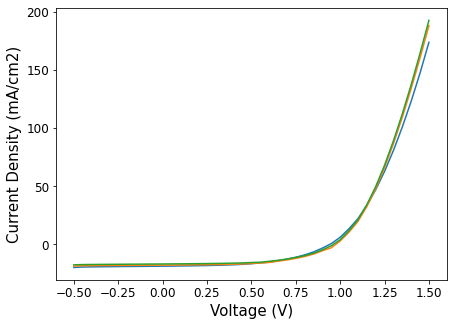

In [6]:
plt.figure(figsize=(7,5))
plt.plot(JV)
plt.xlabel('Voltage (V)', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Current Density (mA/cm2)', fontsize=15)
plt.yticks(fontsize=12)
plt.show()

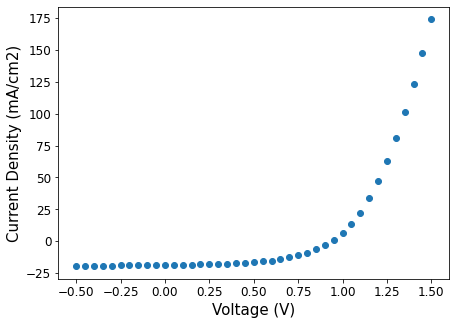

In [7]:
plt.figure(figsize=(7,5))
plt.plot(JV['1'], 'o')
plt.xlabel('Voltage (V)', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Current Density (mA/cm2)', fontsize=15)
plt.yticks(fontsize=12)
plt.show()

# Defining diode equaiton

$$J(V) = J_{D} \Big(exp(A V) - 1\Big) - J_{sc}$$

In [8]:
J = lambda V, Jsc, A, Jd, n : Jd*(np.exp(A*V/n)-1)-Jsc

In [9]:
my_fit, params = opt.curve_fit(J, JV.index.to_list(), JV['1'].values)

fit1 = pd.DataFrame({'fit1':J(JV.index, my_fit[0], my_fit[1], my_fit[2], my_fit[3])}, index=JV.index.to_list())
fit1['Power'] = J(JV.index, my_fit[0], my_fit[1], my_fit[2], my_fit[3])*JV.index
fit1.head()

,fit1,Power
-0.50,-20.581369,10.290685
-0.45,-20.558265,9.251219
-0.40,-20.530396,8.212158
-0.35,-20.496778,7.173872
-0.30,-20.456228,6.136868


In [10]:
my_fit

array([19.96283255,  1.69055817,  0.73056271,  0.45079554])

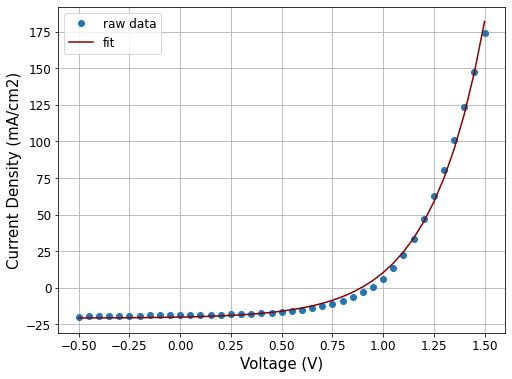

In [11]:
plt.figure(figsize=(8,6)).set_facecolor('white')
plt.plot(JV['1'], 'o', label='raw data')
plt.plot(fit1['fit1'], color='darkred', label='fit')
plt.xlabel('Voltage (V)', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Current Density (mA/cm2)', fontsize=15)
plt.yticks(fontsize=12)
plt.grid(axis='both')
plt.legend(fontsize=12)
plt.show()

## Plotting generated power (from fitted JV)

#### We only care about the power that is negative, because this means that it is generated by the cell - so only plotting these points

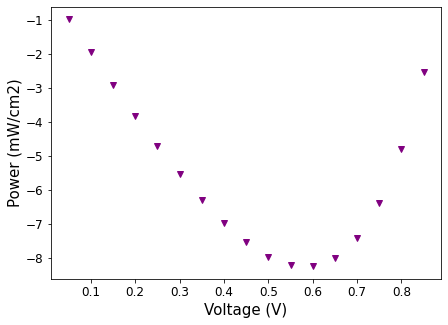

In [12]:
plt.figure(figsize=(7,5))
plt.plot(fit1[fit1['Power']<0]['Power'], 'v', color='purple')
plt.xlabel('Voltage (V)', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Power (mW/cm2)', fontsize=15)
plt.yticks(fontsize=12)
plt.show()

In [13]:
JSC = my_fit[0]
VOC = my_fit[3]/my_fit[1]*np.log(JSC/my_fit[2]+1)

In [14]:
power_x = np.arange(0,VOC,0.01)
power = J(power_x, my_fit[0], my_fit[1], my_fit[2], my_fit[3])*power_x

VMPP = power_x[power.argmin()]
JMPP = np.abs(J(VMPP, my_fit[0], my_fit[1], my_fit[2], my_fit[3]))

FF = (VMPP*JMPP)/(VOC*JSC)*100

PCE = FF*JSC*VOC/100

In [15]:
diff = np.abs(JV.index.to_list()-VOC)
Vi = diff.argmin()-3
Vf = diff.argmin()+3

y = lambda x, m, b : m*x + b

lin_fit, params = opt.curve_fit(y, 
                               JV.index[Vi:Vf+1].to_list(),
                               JV['1'][JV.index[Vi:Vf+1].to_list()].values)

RS = 1/lin_fit[0]*10**3

RS_DF = pd.DataFrame({'Rs_fit':y(JV.index[Vi:Vf+1],lin_fit[0],lin_fit[1])},
                     index=JV.index[Vi:Vf+1].to_list())

In [16]:
diff = np.abs(JV.index.to_list())
Vi = diff.argmin()-3
Vf = diff.argmin()+3

lin_fit, params = opt.curve_fit(y, 
                               JV.index[Vi:Vf+1].to_list(),
                               JV['1'][JV.index[Vi:Vf+1].to_list()].values)

RSH = 1/lin_fit[0]*10**3

RSH_DF = pd.DataFrame({'Rsh_fit':y(JV.index[Vi:Vf+1],lin_fit[0],lin_fit[1])},
                     index=JV.index[Vi:Vf+1].to_list())

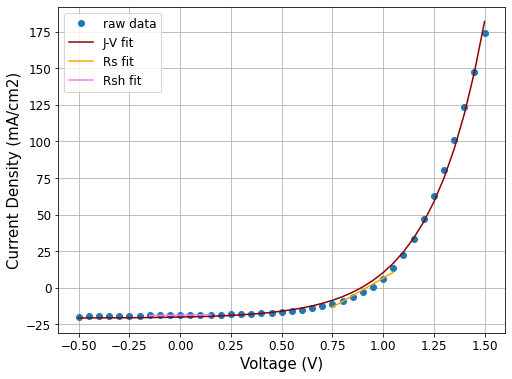

In [17]:
plt.figure(figsize=(8,6)).set_facecolor('white')
plt.plot(JV['1'], 'o', label='raw data')
plt.plot(fit1['fit1'], color='darkred', label='J-V fit')
plt.plot(RS_DF, color='orange', label='Rs fit')
plt.plot(RSH_DF, color='violet', label='Rsh fit')
plt.xlabel('Voltage (V)', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Current Density (mA/cm2)', fontsize=15)
plt.yticks(fontsize=12)
plt.grid(axis='both')
plt.legend(fontsize=12)
plt.show()

# Iterating over the three pixels

In [18]:
chars_index = ['PCE (%)','Jsc (mA/cm2)','Voc (V)','FF (%)','Rsh (Ohm cm2)','Rs (Ohm cm2)']
chars = pd.DataFrame({'1':[0 for i in chars_index], '2':[0 for i in chars_index], '3':[0 for i in chars_index]}, 
                     index=chars_index)

for col in JV.columns.to_list():
    my_fit, params = opt.curve_fit(J, JV.index.to_list(), JV[col].values)
    JSC = my_fit[0]
    VOC = my_fit[3]/my_fit[1]*np.log(JSC/my_fit[2]+1)    
    
    power_x = np.arange(0,VOC,0.01)
    power = J(power_x, my_fit[0], my_fit[1], my_fit[2], my_fit[3])*power_x
    
    VMPP = power_x[power.argmin()]
    JMPP = np.abs(J(VMPP, my_fit[0], my_fit[1], my_fit[2], my_fit[3]))
    
    FF = (VMPP*JMPP)/(VOC*JSC)*100
    PCE = FF*JSC*VOC/100
    
    diff = np.abs(JV.index.to_list())
    Vi = diff.argmin()-3
    Vf = diff.argmin()+3
    lin_fit, params = opt.curve_fit(y, 
                                   JV.index[Vi:Vf+1].to_list(),
                                   JV[col][JV.index[Vi:Vf+1].to_list()].values)
    
    RSH = 1/lin_fit[0]*10**3
    
    diff = np.abs(JV.index.to_list()-VOC)
    Vi = diff.argmin()-3
    Vf = diff.argmin()+3
    lin_fit, params = opt.curve_fit(y, 
                                   JV.index[Vi:Vf+1].to_list(),
                                   JV[col][JV.index[Vi:Vf+1].to_list()].values)
    
    RS = 1/lin_fit[0]*10**3
    
    chars[col] = [PCE,JSC,VOC,FF,RSH,RS]
    

chars

,1,2,3
PCE (%),8.272092,8.419759,7.866267
Jsc (mA/cm2),19.962833,19.469934,18.553276
Voc (V),0.891628,0.901772,0.888193
FF (%),46.473916,47.955509,47.735425
Rsh (Ohm cm2),623.405315,821.061400,871.633326
Rs (Ohm cm2),12.611349,14.010240,13.581013


In [47]:
compare_DF = data[['1','2','3']][1:8].drop(6)
compare_DF

,1,2,3
1,9.151790,9.355109,8.871294
2,18.686320,17.791890,16.817960
3,0.940674,0.974644,0.961021
4,52.064650,53.948680,54.888460
5,863.174800,863.405500,1225.341000
7,12.880840,8.488877,9.662576


In [20]:
char_ratio = pd.DataFrame(chars.values/compare_DF.values, 
                         index=['PCE','Jsc','Voc','FF','Rsh','Rs'],
                         columns=['Pixel 1', 'Pixel 2', 'Piexl 3'])

char_ratio

,Pixel 1,Pixel 2,Piexl 3
PCE,0.903877,0.900017,0.886710
Jsc,1.068313,1.094315,1.103182
Voc,0.947861,0.925232,0.924218
FF,0.892619,0.888910,0.869681
Rsh,0.722224,0.950957,0.711339
Rs,0.979078,1.650423,1.405527


# Trying a slightly different method to measure performance

- Finding MPP directly from the P-V curve,

- Fitting straight lines on either side of this point in the J-V,

- Using these lines to estimate Jsc, Voc, and the resistances

In [21]:
power = JV['1']*JV.index

power.argmin()

22

In [22]:
JV.index[JV.index < JV.index[power.argmin()]]

Float64Index([ -0.5, -0.45,  -0.4, -0.35,  -0.3, -0.25,  -0.2, -0.15,  -0.1,
              -0.05,  -0.0,  0.05,   0.1,  0.15,   0.2,  0.25,   0.3,  0.35,
                0.4,  0.45,   0.5,  0.55],
             dtype='float64')

In [23]:
Vi_l1 = JV.index[JV.index < 0][-2]
Vf_l1 = JV.index[JV.index < JV.index[power.argmin()]][-4]
lin1_fit, params = opt.curve_fit(y,
                        JV[Vi_l1:Vf_l1].index,
                        JV['1'][Vi_l1:Vf_l1].values)

JSC = lin1_fit[1]
RSH = 1/lin1_fit[0]*10**3

line1 = pd.DataFrame({'line1':y(JV[Vi_l1:Vf_l1].index, lin1_fit[0], lin1_fit[1])}, index=JV[Vi_l1:Vf_l1].index)

Vi_l2 = JV.index[JV.index > JV.index[power.argmin()]][4]
Vf_l2 = JV['1'][JV['1']>0].index[2]
lin2_fit, params = opt.curve_fit(y,
                        JV[Vi_l2:Vf_l2].index,
                        JV['1'][Vi_l2:Vf_l2].values)

VOC = -lin2_fit[1]/lin2_fit[0]
RS = 1/lin2_fit[0]*10**3

line2 = pd.DataFrame({'line2':y(JV[Vi_l2:Vf_l2].index, lin2_fit[0], lin2_fit[1])}, index=JV[Vi_l2:Vf_l2].index)

VMPP = JV.index[power.argmin()]
JMPP = -JV['1'][VMPP]

FF = VMPP*JMPP/(VOC*JSC)*100
PCE = FF*VOC*JSC/100

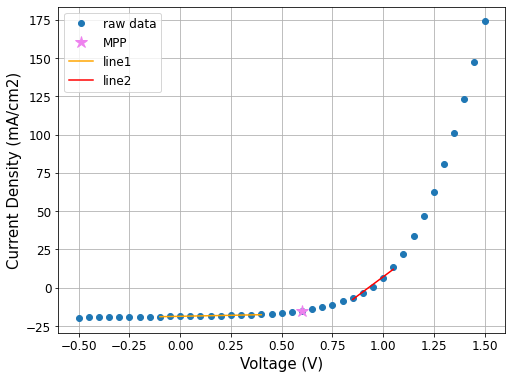

In [24]:
plt.figure(figsize=(8,6)).set_facecolor('white')
plt.plot(JV['1'], 'o', label='raw data')
plt.plot(VMPP, -JMPP, '*', color='violet', ms=12, label='MPP')
plt.plot(line1, color='orange', label='line1')
plt.plot(line2, color='red', label='line2')
plt.xlabel('Voltage (V)', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Current Density (mA/cm2)', fontsize=15)
plt.yticks(fontsize=12)
plt.grid(axis='both')
plt.legend(fontsize=12)
plt.show()

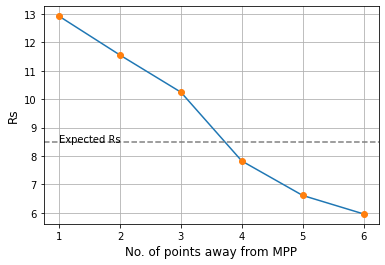

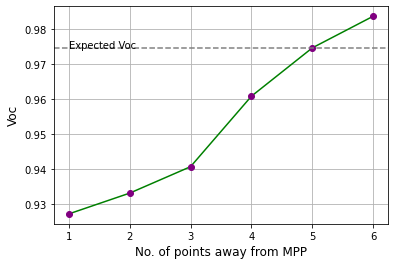

In [56]:
column = '2'
power = JV[column]*JV.index

Vi_l2 = JV.index[JV.index > JV.index[power.argmin()]][0]
Vf_l2 = JV[column][JV[column]>0].index[2]

Vstep = JV.index[1]-JV.index[0]
width = Vf_l2-Vi_l2
dist = []
Rs = []
Voc = []
while width > Vstep*2:
    lin2_fit, params = opt.curve_fit(y,
                                     JV[Vi_l2:Vf_l2].index,
                                     JV[column][Vi_l2:Vf_l2].values)
    dist.append((Vi_l2 - JV.index[power.argmin()])/Vstep)
    Rs.append(1/lin2_fit[0]*10**3)
    Voc.append(-lin2_fit[1]/lin2_fit[0])
    Vi_l2 += Vstep
    width = Vf_l2-Vi_l2
    
Rs_DF = pd.DataFrame(Rs, index=dist)
Voc_DF = pd.DataFrame(Voc, index=dist)

plt.plot(Rs_DF)
plt.plot(Rs_DF, 'o')
plt.axhline(compare_DF[column][7], color='grey', linestyle='--')
plt.text(1,compare_DF[column][7],'Expected Rs')
plt.ylabel('Rs', fontsize=12)
plt.xlabel('No. of points away from MPP', fontsize=12)
plt.grid(axis='both')
plt.show()

plt.plot(Voc_DF, color='green')
plt.plot(Voc_DF, 'o', color='purple')
plt.axhline(compare_DF[column][3], color='grey', linestyle='--')
plt.text(1,compare_DF[column][3], 'Expected Voc')
plt.ylabel('Voc', fontsize=12)
plt.xlabel('No. of points away from MPP', fontsize=12)
plt.grid(axis='both')
plt.show()

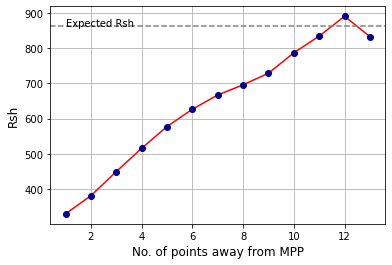

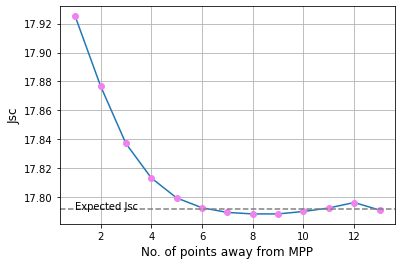

In [55]:
column = '2'
power = JV[column]*JV.index

Vi_l1 = JV.index[JV.index < 0][-2]
Vf_l1 = JV.index[JV.index < JV.index[power.argmin()]][-1]

Vstep = JV.index[1]-JV.index[0]
width = Vf_l1-Vi_l1
dist = []
Rsh = []
Jsc = []
while width > Vstep*2:
    lin1_fit, params = opt.curve_fit(y,
                                     JV[Vi_l1:Vf_l1].index,
                                     JV[column][Vi_l1:Vf_l1].values)
    dist.append((JV.index[power.argmin()] - Vf_l1)/Vstep)
    Rsh.append(1/lin1_fit[0]*10**3)
    Jsc.append(-lin1_fit[1])
    Vf_l1 -= Vstep
    width = Vf_l1-Vi_l1
    
Rsh_DF = pd.DataFrame(Rsh, index=dist)
Jsc_DF = pd.DataFrame(Jsc, index=dist)

plt.plot(Rsh_DF, color='red')
plt.plot(Rsh_DF, 'o', color='darkblue')
plt.axhline(compare_DF[column][5], color='grey', linestyle='--')
plt.text(1,compare_DF[column][5],'Expected Rsh')
plt.ylabel('Rsh', fontsize=12)
plt.xlabel('No. of points away from MPP', fontsize=12)
plt.grid(axis='both')
plt.show()

plt.plot(Jsc_DF)
plt.plot(Jsc_DF, 'o', color='violet')
plt.axhline(compare_DF[column][2], color='grey', linestyle='--')
plt.text(1,compare_DF[column][2],'Expected Jsc')
plt.ylabel('Jsc', fontsize=12)
plt.xlabel('No. of points away from MPP', fontsize=12)
plt.grid(axis='both')
plt.show()

## Using this one method to calculate both the Rs and Voc has a play-off... Maybe I should use an independent method to calculate Rs so I do not sacrifice the accuracy of my Voc estimation. 

### The shape of the curves and the ideal point to start at to estimate these values changes slightly from pixel to pixel. 

In [26]:
chars_index = ['PCE (%)','Jsc (mA/cm2)','Voc (V)','FF (%)','Rsh (Ohm cm2)','Rs (Ohm cm2)']
chars_2 = pd.DataFrame({'1':[0 for i in chars_index], '2':[0 for i in chars_index], '3':[0 for i in chars_index]}, 
                     index=chars_index)

for col in JV.columns.to_list():
    power = JV[col]*JV.index
    
    Vi_l1 = JV.index[JV.index < 0][-2]
    Vf_l1 = JV.index[JV.index < JV.index[power.argmin()]][-4]
    lin1_fit, params = opt.curve_fit(y,
                                     JV[Vi_l1:Vf_l1].index,
                                     JV[col][Vi_l1:Vf_l1].values)
    JSC = -lin1_fit[1]
    RSH = 1/lin1_fit[0]*10**3
    
    Vi_l2 = JV.index[JV.index > JV.index[power.argmin()]][4]
    Vf_l2 = JV[col][JV[col]>0].index[2]
    lin2_fit, params = opt.curve_fit(y,
                                     JV[Vi_l2:Vf_l2].index,
                                     JV[col][Vi_l2:Vf_l2].values)
    VOC = -lin2_fit[1]/lin2_fit[0]
    RS = 1/lin2_fit[0]*10**3
    
    VMPP = JV.index[power.argmin()]
    JMPP = -JV[col][VMPP]
    
    FF = VMPP*JMPP/(VOC*JSC)*100
    PCE = FF*VOC*JSC/100
    
    chars_2[col] = [PCE,JSC,VOC,FF,RSH,RS]
    
chars_2

,1,2,3
PCE (%),9.151788,9.355112,8.871291
Jsc (mA/cm2),18.686571,17.813364,16.821697
Voc (V),0.928119,0.960824,0.951647
FF (%),52.768222,54.658687,55.416744
Rsh (Ohm cm2),385.231482,515.824065,567.075291
Rs (Ohm cm2),10.160506,7.823565,7.742899


In [27]:
char_ratio_2 = pd.DataFrame(chars_2.values/compare_DF.values, 
                         index=['PCE','Jsc','Voc','FF','Rsh','Rs'],
                         columns=['Pixel 1', 'Pixel 2', 'Piexl 3'])

char_ratio_2

,Pixel 1,Pixel 2,Piexl 3
PCE,1.000000,1.000000,1.000000
Jsc,1.000013,1.001207,1.000222
Voc,0.986653,0.985821,0.990247
FF,1.013513,1.013161,1.009625
Rsh,0.446296,0.597430,0.462790
Rs,0.788808,0.921625,0.801329


## Using this simple method, I can predict most parameters to great accuracy - this must be the method that is used in the LabView code!

### However, the resistances are far from perfect. I am severely underestimating both the Rsh and Rs resistances with this method alone. 